# Total Energy Prediction - Neural Network

## Introduction

In this notebook we will machine-learn the relationship between a molecular descriptor and total energy using neural networks.

The energy of ~134k molecules was calculated at the CCSD level.

## Setup

In [4]:
# --- INITIAL DEFINITIONS ---
from sklearn.neural_network import MLPRegressor
import numpy, math, random
import matplotlib.pyplot as plt
from scipy.sparse import load_npz
from mpl_toolkits.mplot3d import Axes3D

from keras.models import Sequential
from keras.layers import Dense

Let's pick a descriptor. Allowed types are:

1. cnt: atom counts
2. bob: bag of bonds
4. soap: smooth overlap of atomic positions; choose from:
    1. soap.sum - all atoms summed together
    4. soap.mean - mean of all atom SOAP
    4. soap.centre - computed at the central point
5. mbtr: many-body tensor representation
6. cm: Coulomb matrix

In [5]:
# TYPE is the descriptor type
TYPE = "cm"

#show descriptor details
print("\nDescriptor details")
desc = open("./data/descriptor."+TYPE.split('.')[0]+".txt","r").readlines()
for l in desc: print(l.strip())
print(" ")


Descriptor details
Coulomb matrixes:

The molecule is represented by a matrix of Coulomb energies [ Z_i Z_j / r_ij ].
On the diagonal we use Z_i^2.4, just because it seems to work ok.
The matrix is then diagonalised and we take its eigenvalues as descriptors.
If a molecule has less than 29 atoms, the descriptor is padded with zeros.

M. Rupp, et al., Physical Review Letters, 108, 058301 (2012)
 


and load the databases with the descriptors (input) and the correct charge densities (output). Databases are quite big, so we can decide how many samples to use for training.

In [6]:
# load input/output data
trainIn = load_npz("./data/energy.input."+TYPE+".npz").toarray()
trainOut = numpy.load("./data/energy.output.npy")
trainIn = trainIn.astype(dtype=numpy.float64, casting='safe')

# decide how many samples to take from the database
samples  = min(trainIn.shape[0], 9000)
vsamples = min(trainIn.shape[0]-samples,1000)
print("training samples:   "+str(samples))
print("validation samples: "+str(vsamples))
print("number of features: {}".format(trainIn.shape[1]))

# split between training and validation
validIn = trainIn[samples:samples+vsamples]
validOut = trainOut[samples:samples+vsamples]

trainIn  = trainIn[0:samples]
trainOut = trainOut[0:samples]

# shift and scale the inputs
train_mean = numpy.mean(trainIn, axis=0)
train_std = numpy.std(trainIn, axis=0)
train_std[train_std==0] = 1
for a in range(trainIn.shape[1]):
    trainIn[:,a] -= train_mean[a]

for a in range(trainIn.shape[1]):
    trainIn[:,a] /= train_std[a]
# also for validation set
for a in range(validIn.shape[1]):
    validIn[:,a] -= train_mean[a]
for a in range(validIn.shape[1]):
    validIn[:,a] /= train_std[a]
    

# show the first few descriptors
print("\nDescriptors for the first 5 molecules:")
print(trainIn[0:5])


training samples:   9000
validation samples: 1000
number of features: 29

Descriptors for the first 5 molecules:
[[-1.06608733 -1.39452007 -0.90522459 -0.52623869 -0.36274555 -0.42590425
  -0.03664981  0.17407117  0.44925896  0.54547294  0.57971502  0.36412393
   0.23746665  0.27432951  0.4064276   0.44780288  0.64129896  0.82657088
   1.04395023 -0.65340703 -0.50941711 -0.35189957 -0.28150486 -0.16047789
  -0.13998514 -0.06157624 -0.05586182 -0.01054151 -0.01054151]
 [-0.89726045 -1.50337726 -0.50995177 -0.08490055  0.31719358 -0.33703079
  -0.40851183  0.11343785 -2.25551878 -0.78786906 -0.84699474 -0.50485996
  -0.3785106  -0.10654303  0.18658595  0.4069259   0.54059222 -1.16577469
  -0.89176109 -0.65340703 -0.50941711 -0.35189957 -0.28150486 -0.16047789
  -0.13998514 -0.06157624 -0.05586182 -0.01054151 -0.01054151]
 [ 4.93845836  2.82067188  4.06545461  5.72565675  5.58022593  1.97316254
   0.58905264  0.6584239   0.5167076  -1.09338133 -1.09375577 -0.62087813
  -0.60143536 -3.7753

Next we setup a multilayer perceptron of suitable size. Out package of choice is scikit-learn, but more efficient ones are available.<br>
Check the scikit-learn <a href="http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html">documentation</a> for a list of parameters.

In [9]:
trainIn.shape

(9000, 29)

In [ ]:
# setup the neural network
nn = MLPRegressor(hidden_layer_sizes=(1000,200,50,50),  activation='tanh', solver='lbfgs', alpha=0.01, 
                  learning_rate='adaptive')

## Training
Now comes the tough part! The idea of training is to evaluate the ANN with the training inputs and measure its error (since we know the correct outputs). It is then possible to compute the derivative (gradient) of the error w.r.t. each parameter (connections and biases). By shifting the parameters in the opposite direction of the gradient, we obtain a better set of parameters, that should give smaller error.
This procedure can be repeated until the error is minimised.


It may take a while...

In [7]:
model = Sequential()
model.add(Dense(units=500, activation='relu', input_shape=(29,)))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

W0313 13:04:51.400012 140123387144000 deprecation_wrapper.py:119] From /appl/soft/ai/miniconda3/envs/tensorflow-1.14.0/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0313 13:04:51.493349 140123387144000 deprecation_wrapper.py:119] From /appl/soft/ai/miniconda3/envs/tensorflow-1.14.0/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0313 13:04:51.934299 140123387144000 deprecation_wrapper.py:119] From /appl/soft/ai/miniconda3/envs/tensorflow-1.14.0/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [8]:
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

W0313 13:04:58.533256 140123387144000 deprecation_wrapper.py:119] From /appl/soft/ai/miniconda3/envs/tensorflow-1.14.0/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [13]:
hist = model.fit(trainIn, trainOut, epochs=15, batch_size=32,validation_data=(validIn, validOut))

Train on 9000 samples, validate on 1000 samples
Epoch 1/15
9000/9000 [==============================] - 1s 68us/step - loss: 169940.2592 - acc: 0.0000e+00 - val_loss: 168702.8590 - val_acc: 0.0000e+00
Epoch 2/15
9000/9000 [==============================] - 1s 68us/step - loss: 169940.2587 - acc: 0.0000e+00 - val_loss: 168702.8590 - val_acc: 0.0000e+00
Epoch 3/15
9000/9000 [==============================] - 1s 68us/step - loss: 169940.2586 - acc: 0.0000e+00 - val_loss: 168702.8590 - val_acc: 0.0000e+00
Epoch 4/15
9000/9000 [==============================] - 1s 67us/step - loss: 169940.2593 - acc: 0.0000e+00 - val_loss: 168702.8590 - val_acc: 0.0000e+00
Epoch 5/15
9000/9000 [==============================] - 1s 67us/step - loss: 169940.2595 - acc: 0.0000e+00 - val_loss: 168702.8590 - val_acc: 0.0000e+00
Epoch 6/15
9000/9000 [==============================] - 1s 68us/step - loss: 169940.2593 - acc: 0.0000e+00 - val_loss: 168702.8590 - val_acc: 0.0000e+00
Epoch 7/15
9000/9000 [============

In [10]:
validMLOut

Help on method predict in module keras.engine.training:

predict(x, batch_size=None, verbose=0, steps=None) method of keras.engine.sequential.Sequential instance
    Generates output predictions for the input samples.
    
    Computation is done in batches.
    
    # Arguments
        x: The input data, as a Numpy array
            (or list of Numpy arrays if the model has multiple inputs).
        batch_size: Integer. If unspecified, it will default to 32.
        verbose: Verbosity mode, 0 or 1.
        steps: Total number of steps (batches of samples)
            before declaring the prediction round finished.
            Ignored with the default value of `None`.
    
    # Returns
        Numpy array(s) of predictions.
    
    # Raises
        ValueError: In case of mismatch between the provided
            input data and the model's expectations,
            or in case a stateful model receives a number of samples
            that is not a multiple of the batch size.



In [ ]:
# use this to change some parameters during training if the NN gets stuck in a bad spot
nn.set_params(solver='lbfgs')

nn.fit(trainIn, trainOut);

Check the ANN quality with a regression plot, showing the mismatch between the exact and NN predicted outputs for the validation set.

Mean Abs Error (training)  :  410.2660622399144
Mean Abs Error (validation):  408.4972060570862


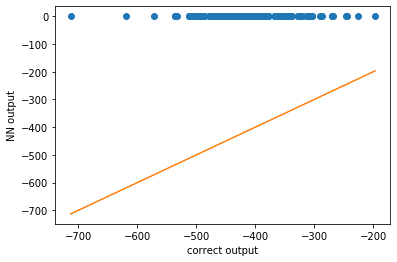

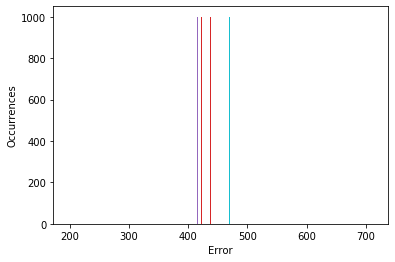

In [11]:
# evaluate the training and validation error
trainMLOut = model.predict(trainIn)
validMLOut = model.predict(validIn)

print ("Mean Abs Error (training)  : ", (numpy.abs(trainMLOut-trainOut)).mean())
print ("Mean Abs Error (validation): ", (numpy.abs(validMLOut-validOut)).mean())

plt.plot(validOut,validMLOut,'o')
plt.plot([min(validOut),max(validOut)],[min(validOut),max(validOut)]) # perfect fit line
plt.xlabel('correct output')
plt.ylabel('NN output')
plt.show()

# error histogram
plt.hist(validMLOut-validOut,50)
plt.xlabel("Error")
plt.ylabel("Occurrences")
plt.show()

# Exercises

### 1. Compare descriptors
Keeping the size of the NN constant, test the accuracy of different descriptors with the same NN size, and find the best one for these systems.

In [ ]:
# DIY code here...

### 2. Combine with Principal Component Analysis - Advanced
Reduce the descriptor size with PCA (check the PCA.ipynb notebook) and train again. Can you get similar accuracy with much smaller networks?